# Importando dependencias

In [ ]:
import pyspark.sql.functions as sf
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql import DataFrame

In [ ]:
from functools import reduce
import subprocess

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', 150)

# Utils

In [ ]:
BASE_GS = "gs://oculto/oculto/PERFIL_LARANJA/"

In [ ]:
def countMissingValues(dataframe: DataFrame) -> DataFrame:
    missing_values = dataframe.select([
        sf.count(sf.when(sf.col(c).isNull(), c)).alias(c) for c in dataframe.columns
    ])

    return missing_values

# Base completa

In [ ]:
BASE_GS_RAW = "gs://oculto/oculto/PERFIL_LARANJA/RAW/"

In [ ]:
DATASET_NAME = 'PERFIL-RAW.parquet'

In [ ]:
path = os.path.join(BASE_GS_RAW, DATASET_NAME)
raw = spark.read.parquet(path)

In [ ]:
# raw.printSchema

# Analise Descritiva

In [ ]:
cols_drop = ['nome', 'situacao']

In [ ]:
raw = raw.drop(*cols_drop)

In [ ]:
f"total de pessoas físicas: {raw.count():,}".replace(',', '.')

'total de pessoas físicas: 183.895.975'

In [ ]:
f"total de colunas: {len(raw.columns)}"

'total de colunas: 133'

In [ ]:
f"total de flags: {len([column for column in raw.columns if column.startswith('flag')])}"

'total de flags: 83'

In [ ]:
raw.filter(sf.col("quantidadeVeiculosPesados") > 0).select(sf.mean(sf.col("quantidadeVeiculosPesados"))).show()

+------------------------------+
|avg(quantidadeVeiculosPesados)|
+------------------------------+
|            1.2944811302083603|
+------------------------------+



In [ ]:
raw.filter(sf.col("quantidadeVeiculosPesados") > 0).select(sf.median(sf.col("quantidadeVeiculosPesados"))).show()

+---------------------------------+
|median(quantidadeVeiculosPesados)|
+---------------------------------+
|                              1.0|
+---------------------------------+



## Booleanas

In [ ]:
dicotomic_columns = [column for column in raw.columns if column.startswith('flag')]

In [ ]:
raw_dicotomic = raw.select(*dicotomic_columns)

In [ ]:
raw_dicotomic.describe().toPandas()

25/01/22 12:38:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,flagFalecidoConfirmado,flagSituacaoRegular,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,flagBaixaRendaFinanciamentoVeiculoPremium,flagBaixaRendaMediaParcelaFinanciamentoAlta,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,flagOperadorAeronave,flagProprietarioAeronave,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioEmpresasMedioPorteBaixaRenda,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaALTA,flagSocioClasseEmpresaFachadaMUITOALTA,flagSocioClasseEmpresaFachadaMEDIO
0,count,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,4039573,4039573,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975
1,mean,1.6802977879205894E-6,1.0,3.5448301682513715E-4,0.08114439698856922,0.2133575898004293,0.20869471993609431,0.04581051325348475,0.034862171398803043,0.004021153807199967,0.041254056811194484,0.030020483047549028,0.0035081246340492225,0.12489865534033576,0.10728245139677473,0.3390676114580539,0.007233497089862897,4.459042673446224E-7,0.11573531177068992,0.3917630714864749,0.3917630714864749,2.8983777377400456E-6,3.888067696968354E-6,0.03516668051054407,0.002429319075635016,0.12201665098977832,0.036094650793743584,0.019490627785627174,2.7553621007746364E-5,2.0886808425252373E-5,0.0014925394642269904,0.0019886079616478827,0.0018553913428502173,0.022769405366267533,5.59011691256429E-6,4.660243379443188E-5,1.3475009444877737E-5,0.03083423114616837,2.1332712692596997E-5,1.0218820721878225E-4,2.

In [ ]:
#colunas sem variancia
flags_to_drop = ['flagSituacaoRegular', 'flagSocioClasseEmpresaFachadaMUITOALTA', 'flagSocioClasseEmpresaFachadaALTA', 'flagSocioEmpresasMedioPorteBaixaRenda']

In [ ]:
raw = raw.drop(*flags_to_drop)

## Numericas

In [ ]:
from pyspark.sql.types import NumericType, StringType

In [ ]:
numeric_columns = [column.name for column in raw.schema.fields if isinstance(column.dataType, NumericType)]
numeric_columns = list(set(numeric_columns) - set(dicotomic_columns))

In [ ]:
f'total de colunas numericas: {len(numeric_columns)}'

'total de colunas numericas: 44'

In [ ]:
raw_numeric = raw.select(*numeric_columns)

In [ ]:
raw_numeric.describe().toPandas()

,summary,quantidadeMaximaEmailsIguaisEmpresasAtivas,quantidadeTelefonesEnderecoConsistente,quantidadePropriedades,quantidadePropriedadesAtivas,quantidadeVeiculosPesados,quantidadeDuplaIdentidadeNomeMae,quantidadeEmails,quantidadeEleicoesComoDoador,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeDoacoesPoliticas,valorMaximoDoado,qtdVeiculosFinanciados,quantidadeDoacoesDescricaoNaoEspecificada,valorTotalImoveis,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeIndicioForteDuplaIdentidade,valorMedioDoado,tempoEmAnosDataNascimentoDataInscricao,valorAreaTotalPropriedadesRurais,quantidadeEmailPadraoSuspeito,valorTotalDividasDau,quantidadeTelefones,valorTotalDoado,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeRelacionamentos,quantidadeAeronaves,quantidadeDuplaIdentidadeNomeDataNascimento,qtdImoveisAltoValor,percentualEmpresasEmLocalEntregaInterna,quantidadeRestituicaoIrpfObservadas,quantidadeEmailNaoConsistenteNomeTitular,qtdImoveisAcimaMediana,quantidadeDuplaIdentidadeCpfMae,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,quantidadeDeclaracoesIrpfObservadas,quantidadeDiferentesprovedoresEmail,idade,RecorrenciaFinanciamentoMaioridade,qtdFinanciamentosVeicularesQuitados,quantidadeMaximaAlteracoesQsa30Dias,qtdImoveis,quantidadeMaximaAlteracoesQsa365Dias,quantidadeCandidatosApoiados,quantidadeMaximaAlteracoesEnderecos12meses
0,count,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,182465951,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,4039573,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975,183895975
1,mean,48.611180429587975,1.3441392504648348,0.025924732719136458,0.0217231562572264,0.008180412866567633,3.8304264136286836E-5,0.6598720771349128,0.02647068811593076,0.013826695307528402,0.045118051115583147,34.478446530490906,0.5147572261981264,0.029993136065104196,7689.076046245045,1.6606127458743998E-4,2.708052745580756E-6,22.428013286704903,22.09547905773441,1.8132501828819412,0.0888612869313752,7396.879276159111,1.4507726773247756,64.58165375006156,1.4742030106966723E-5,1.4443189906685017,8.663049857399E-5,0.010893669641219716,0.0021523037684756286,0.00391537904209247,0.6298926118421025,0.34756046726960715,0.5063936213060143,2.708052745580756E-6,0.0014777648069785106,5.355266106286448,0.5773500045338132,43.45066442590709,5.95104763293507,0.5281758776938973,0.010537049546625477,0.031130197384689903,0.12314204810627312,0.028208703317187882,0.0
2,stddev,1747.047452038072,1.3126027255845083,0.23929568086571906,0.21856932166658558,0.14661134038316814,0.006223098100616482,0.9897213434028782,0.20966814670324313,0.15751608428251954,0.8491388823680615,7512.918228298724,1.300269822743725,0.42485322957756655,316885.1005505165,0.05362774776934618,0.001645613996889016,1666.9785245801147,11.948302760925824,403.28794950116446,0.32001334174158474,2491070.9182480616,1.3404406746342936,11071.630884393708,0.004623418468702102,2.917466836302557,0.012340165274291055,0.22498282787423227,0.06172354370723389,0.06122651632380301,1.8457919228774327,0.6864208531172664,1.0339491810738388,0.001645613996889016,0.049653795230371785,4.428318221201347,0.8423208646279178,18.9881277574597,12.39908016684065,1.430507899123121,1.2941332416832136,0.5122310684111709,9.043214978161537,0.49651329034835856,0.0
3,min,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,12,0.0,0,0,0,0,0,0
4,max,74236,93,140,140,520,2,23,12,1093.5,3153,8.600793955E7,257,762,2.61592773994E9,386,1,2.000046E7,194.93,2772670.0,10,8.88686503218E9,276,1.0081368468999998E8,17,258,17,64,121,1.0,23,22,817,1,145,26,19,204,132.0,318,581,3963,1795,1094,0


In [ ]:
numeric_to_drop = ['quantidadeMaximaAlteracoesEnderecos12meses', 'quantidadeMaximaEmailsIguaisEmpresasAtivas',
                   'quantidadeEmails',
                  ]
raw = raw.drop(*numeric_to_drop)

## Categoricas

In [ ]:
categoric_columns = [column.name for column in raw.schema.fields if isinstance(column.dataType, StringType)]
# categoric_columns = list(set(numeric_columns) - set(dicotomic_columns))

In [ ]:
categoric_columns.remove('cpf')

In [ ]:
categoric_columns

['profissao',
 'historicoAtrasoFinanciamentoVeicular',
 'recorrenciaFinanciamentoVeicular']

In [ ]:
raw.groupBy("profissao").count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------------------------+---------+
|profissao                                        |count    |
+-------------------------------------------------+---------+
|NULL                                             |149396786|
|MICROEMPREENDEDOR                                |9444452  |
|PRODUTOR RURAL                                   |6292248  |
|SERVIDOR PUBLICO                                 |1489548  |
|TRANSPORTADOR AUTONOMO                           |1353718  |
|PESCADOR ARTESANAL                               |1247183  |
|PROFESSOR                                        |1070681  |
|ADMINISTRADORES                                  |1012574  |
|TECNICO DE ENFERMAGEM                            |867299   |
|AGENTES, ASSISTENTES E AUXILIARES ADMINISTRATIVOS|438937   |
|ENFERMEIRO                                       |375566   |
|AGENTE COMUNITARIO DE SAUDE                      |370374   |
|OPERADORES DO COMERCIO EM LOJAS E MERCADOS       |365944   |
|CONTADO

In [ ]:
raw.groupBy("historicoAtrasoFinanciamentoVeicular").count().orderBy("count", ascending=False).show(truncate=False)

+------------------------------------+---------+
|historicoAtrasoFinanciamentoVeicular|count    |
+------------------------------------+---------+
|SEM INFORMACAO                      |136888554|
|NAO ATRASA                          |36473790 |
|ATRASA                              |10533631 |
+------------------------------------+---------+



In [ ]:
raw.groupBy("recorrenciaFinanciamentoVeicular").count().orderBy("count", ascending=False).show(truncate=False)

+--------------------------------+---------+
|recorrenciaFinanciamentoVeicular|count    |
+--------------------------------+---------+
|SEM INFORMACAO                  |134816121|
|SEM RECORRENCIA                 |23851736 |
|DE 3 A 5 ANOS                   |6820848  |
|DE 5 A 10 ANOS                  |6062511  |
|DE 2 A 3 ANOS                   |4415148  |
|DE 1 A 2 ANOS                   |3714197  |
|MAIS QUE 10 ANOS                |1924113  |
|DE 180 DIAS A 1 ANO             |1257864  |
|DE 90 A 180 DIAS                |457686   |
|ATE 30 DIAS                     |318855   |
|DE 30 A 90 DIAS                 |256896   |
+--------------------------------+---------+



### Recorrencia financiamento

In [ ]:
! pip install -q neoway-dataviz-tools

In [ ]:
import dataviz_tools.categorical as categorical_viz

(DataFrame[recorrenciaFinanciamentoVeicular: string, count: bigint],
 <Figure size 1800x500 with 1 Axes>)

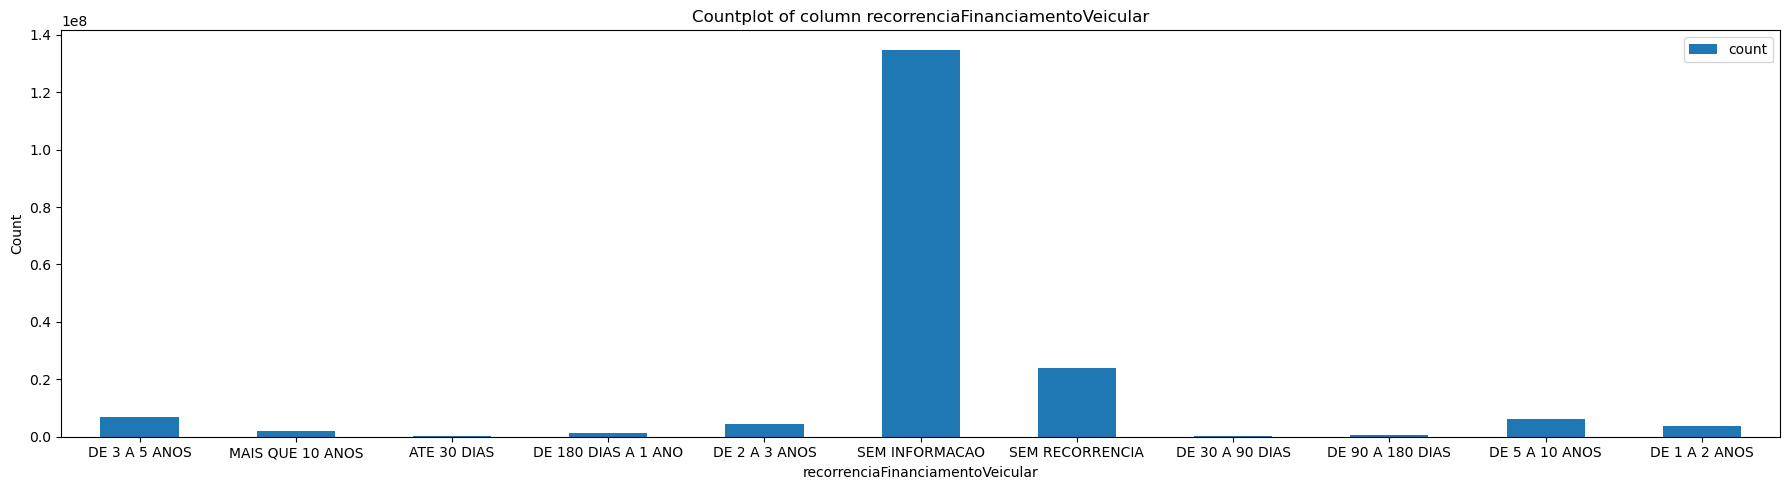

In [ ]:
categorical_viz.plot_countplot(raw, "recorrenciaFinanciamentoVeicular", figsize= (18, 5), title='' )

In [ ]:
raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "ATE 30 DIAS").select(sf.mean(sf.col("idade"))).show()

+-----------------+
|       avg(idade)|
+-----------------+
|53.73504257421085|
+-----------------+



In [ ]:
raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "ATE 30 DIAS").limit(15).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailNaoConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaMEDIO,quantidadeTelefones,quantidadeTelefonesEnderecoConsistente
0,00058350543,45,None,None,0,20.00,0,0,0,0,0,None,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0.0,0.

In [ ]:
raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 30 A 90 DIAS").limit(15).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailNaoConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaMEDIO,quantidadeTelefones,quantidadeTelefonesEnderecoConsistente
0,00101020279,34,None,None,0,15.99,0,0,0,1,0,None,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1300.0

In [ ]:
raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 90 A 180 DIAS").limit(15).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailNaoConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaMEDIO,quantidadeTelefones,quantidadeTelefonesEnderecoConsistente
0,00006397107,42,None,None,0,18.85,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000

In [ ]:
raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 180 DIAS A 1 ANO").limit(15).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailNaoConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaMEDIO,quantidadeTelefones,quantidadeTelefonesEnderecoConsistente
0,00046158758,55,None,None,0,21.69,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000

In [ ]:
raw_financiamento = raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "ATE 30 DIAS")
total_size = raw_financiamento.count()
(
    raw_financiamento
    .groupBy("flagBaixaRenda")
    .agg(
        sf.count("*").alias("count"),
    )
    .withColumn('proportion', sf.round(sf.col('count') / sf.lit(total_size), 5))
    .show(truncate=False)
)

+--------------+------+----------+
|flagBaixaRenda|count |proportion|
+--------------+------+----------+
|1             |163015|0.51125   |
|0             |155840|0.48875   |
+--------------+------+----------+



In [ ]:
raw_financiamento = raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 30 A 90 DIAS")
total_size = raw_financiamento.count()
(
    raw_financiamento
    .groupBy("flagBaixaRenda")
    .agg(
        sf.count("*").alias("count"),
    )
    .withColumn('proportion', sf.round(sf.col('count') / sf.lit(total_size), 5))
    .show(truncate=False)
)

+--------------+------+----------+
|flagBaixaRenda|count |proportion|
+--------------+------+----------+
|1             |139551|0.54322   |
|0             |117345|0.45678   |
+--------------+------+----------+



In [ ]:
raw_financiamento = raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 90 A 180 DIAS")
total_size = raw_financiamento.count()
(
    raw_financiamento
    .groupBy("flagBaixaRenda")
    .agg(
        sf.count("*").alias("count"),
    )
    .withColumn('proportion', sf.round(sf.col('count') / sf.lit(total_size), 5))
    .show(truncate=False)
)

+--------------+------+----------+
|flagBaixaRenda|count |proportion|
+--------------+------+----------+
|1             |237919|0.51983   |
|0             |219767|0.48017   |
+--------------+------+----------+



In [ ]:
raw_financiamento = raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 180 DIAS A 1 ANO")
total_size = raw_financiamento.count()
(
    raw_financiamento
    .groupBy("flagBaixaRenda")
    .agg(
        sf.count("*").alias("count"),
    )
    .withColumn('proportion', sf.round(sf.col('count') / sf.lit(total_size), 5))
    .show(truncate=False)
)

+--------------+------+----------+
|flagBaixaRenda|count |proportion|
+--------------+------+----------+
|1             |582181|0.46283   |
|0             |675683|0.53717   |
+--------------+------+----------+



In [ ]:
raw_financiamento = raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "DE 5 A 10 ANOS")
total_size = raw_financiamento.count()
(
    raw_financiamento
    .groupBy("flagBaixaRenda")
    .agg(
        sf.count("*").alias("count"),
    )
    .withColumn('proportion', sf.round(sf.col('count') / sf.lit(total_size), 5))
    .show(truncate=False)
)

+--------------+-------+----------+
|flagBaixaRenda|count  |proportion|
+--------------+-------+----------+
|1             |2197664|0.3625    |
|0             |3864847|0.6375    |
+--------------+-------+----------+



In [ ]:
raw_financiamento = raw.filter(sf.col("recorrenciaFinanciamentoVeicular") == "MAIS QUE 10 ANOS")
total_size = raw_financiamento.count()
(
    raw_financiamento
    .groupBy("flagBaixaRenda")
    .agg(
        sf.count("*").alias("count"),
    )
    .withColumn('proportion', sf.round(sf.col('count') / sf.lit(total_size), 5))
    .show(truncate=False)
)

+--------------+-------+----------+
|flagBaixaRenda|count  |proportion|
+--------------+-------+----------+
|1             |766272 |0.39825   |
|0             |1157841|0.60175   |
+--------------+-------+----------+



# Analises

In [ ]:
# perfil divergente -> plataforma idade está em 42 anos
raw.filter(sf.col("tempoEmAnosDataNascimentoDataInscricao") >= 190).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,flagSituacaoRegular,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeEmails,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMaximaEmailsIguaisEmpresasAtivas,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesEnderecos12meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasMedioPorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioClasseEmpresa

In [ ]:
raw.filter((sf.col("tempoEmAnosDataNascimentoDataInscricao") >= 150) & (sf.col("tempoEmAnosDataNascimentoDataInscricao") <= 190)).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,flagSituacaoRegular,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeEmails,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMaximaEmailsIguaisEmpresasAtivas,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesEnderecos12meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasMedioPorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioClasseEmpresa

In [ ]:
raw.filter((sf.col("tempoEmAnosDataNascimentoDataInscricao") >= 120) & (sf.col("tempoEmAnosDataNascimentoDataInscricao") <= 150)).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,flagSituacaoRegular,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeEmails,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMaximaEmailsIguaisEmpresasAtivas,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesEnderecos12meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasMedioPorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioClasseEmpresa

In [ ]:
raw.filter(sf.col("quantidadeMaximaEmailsIguaisEmpresasAtivas") == 74236).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeEmails,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMaximaEmailsIguaisEmpresasAtivas,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaMEDIO,quantidadeTelefones,quantidadeTelefonesEnderecoConsistente
0,01252574495,42,None,None,0,

In [ ]:
raw.filter(sf.col("quantidadeMaximaEmailsIguaisEmpresasAtivas") == 74236).groupBy("profissao").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|           profissao|count|
+--------------------+-----+
|                NULL|66947|
|   MICROEMPREENDEDOR| 3189|
|           ARQUITETO| 2130|
|      MEDICO CLINICO| 1525|
|     ADMINISTRADORES| 1206|
| CORRETOR DE SEGUROS| 1180|
|    SERVIDOR PUBLICO| 1145|
|   PSICOLOGO CLINICO|  974|
|          ENGENHEIRO|  947|
|       ADMINISTRADOR|  863|
|    MEDICO RESIDENTE|  738|
|      PRODUTOR RURAL|  705|
|FISIOTERAPEUTA GERAL|  658|
|            CONTADOR|  576|
|AGENTES, ASSISTEN...|  508|
|            DENTISTA|  503|
|     MEDICO PEDIATRA|  345|
|       FONOAUDIOLOGO|  335|
|          ENFERMEIRO|  323|
|CIRURGIAO DENTIST...|  298|
+--------------------+-----+
only showing top 20 rows



>>

Casos de dupla identidade fortemente associados a idade. Em media, a idade dos casos é de 57 anos.

In [ ]:
raw.filter(sf.col("quantidadeDuplaIdentidadeNomeMae") == 2).toPandas()

,cpf,idade,indicioFalecimento,dataIndicioFalecimento,flagFalecidoConfirmado,tempoEmAnosDataNascimentoDataInscricao,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,flagBeneficiarioBPC,flagVulneravelBPC,flagBeneficiarioBolsaFamilia,flagBeneficiarioAuxilioBrasil,flagBeneficiarioAuxilioEmergencial,flagBeneficiarioSeguroDefeso,flagBeneficiarioGarantiaSafra,flagBeneficiarioNovoBolsaFamilia,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,quantidadeCandidatosApoiados,quantidadeEleicoesComoDoador,valorMedioDoado,valorTotalDoado,quantidadeDoacoesDescricaoNaoEspecificada,valorMaximoDoado,quantidadeDoacoesPoliticas,flagContratoPublicoBeneficiarioProgramasSociais,flagLaranja,quantidadeEmails,quantidadeDiferentesprovedoresEmail,quantidadeEmailPadraoSuspeito,quantidadeEmailConsistenteNomeTitular,flagAreaUrbanaBaixaDensidadeEdificios,flagAglomeradoRural,flagAreaRural,flagFavelaOuComunidadeUrbana,flagDividaDauCresceu180Dias,valorTotalDividasDau,flagFinanciamentoImobiliarioAltoValorBeneficiaria,flagFinanciamentoImobiliarioAltoValorBaixaRenda,qtdVeiculosFinanciados,qtdFinanciamentosVeicularesQuitados,flagBaixaRendaFinanciamentoVeiculoPremium,historicoAtrasoFinanciamentoVeicular,flagBaixaRendaMediaParcelaFinanciamentoAlta,recorrenciaFinanciamentoVeicular,flagBeneficiarioProgramasSociaisFinanciamentoMediaParcelaAlta,RecorrenciaFinanciamentoMaioridade,quantidadeRestituicaoIrpfObservadas,quantidadeDeclaracoesIrpfObservadas,flagAlterouBancoDeclaracaoIrpfUltimos5Anos,flagBancarizacaoABeneficiarioProgramasSociais,flagPatrimonioABeneficiarioProgramasSociais,flagAtivosComCotaABeneficiarioProgramasSociais,flagAtivosSemCotaABeneficiarioProgramasSociais,flagBancarizacaoABaixaRenda,flagPatrimonioABaixaRenda,flagAtivosComCotaABaixaRenda,flagAtivosSemCotaABaixaRenda,flagSocioProcessoJudicialLavagemDinheiro,flagProcessoJudicialCorrupcao,flagProcessoJudicialLavagem,flagProcessoJudicialFraude,flagProcessoJudicialRouboFurtos,flagSocioProcessoJudicialFraude,flagProcessoJudicialCobranca,flagSocioProcessoJudicialCorrupcao,flagSocioProcessoJudicialTributario,quantidadeDuplaIdentidadeNomeDataNascimento,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,qtdImoveis,valorTotalImoveis,qtdImoveisAcimaMediana,qtdImoveisAltoValor,flagBaixaRendaValorImobiliarioAcimaPercentil90,flagBeneficiarioValorImobiliarioAcimaPercentil90,quantidadeVeiculosPesados,quantidadeVeiculosPesadosAnoFabricacaoEntre0E4AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre5E9AnosAtras,quantidadeVeiculosPesadosAnoFabricacaoEntre10E14AnosAtras,valorAreaTotalPropriedadesRurais,quantidadePropriedades,quantidadePropriedadesAtivas,flagOperadorAeronave,flagProprietarioAeronave,quantidadeAeronaves,flagBaixaRendaAeronave,flagBeneficiarioAeronave,flagBeneficiarioVeiculoPesado,quantidadeRelacionamentos,flagPrimeiroGrauProcessoJudicialCorrupcao,flagPrimeiroGrauProcessoJudicialLavagem,flagPrimeiroGrauProcessoJudicialFraude,flagPrimeiroGrauProcessoJudicialRouboFurtos,flagPrimeiroGrauProcessoJudicialCobranca,flagSegundoGrauProcessoJudicialCorrupcao,flagSegundoGrauProcessoJudicialLavagem,flagSegundoGrauProcessoJudicialFraude,flagSegundoGrauProcessoJudicialRouboFurtos,flagSegundoGrauProcessoJudicialCobranca,flagRendaSemInformacao,flagBaixaRenda,flagMediaRenda,flagAltaRenda,flagSocioDuplaId,percentualEmpresasEmLocalEntregaInterna,flagSocioEmpresaComSocioFalecido,quantidadeMaximaEmailsIguaisEmpresasAtivas,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,quantidadeMaximaAlteracoesQsa365Dias,quantidadeMaximaAlteracoesQsa30Dias,flagSocioEmpresasGrandePorteBaixaRenda,flagSocioBeneficiarioProgramaSocial,flagSocioClasseEmpresaFachadaMEDIO,quantidadeTelefones,quantidadeTelefonesEnderecoConsistente
0,44423292734,70,None,None,0,

In [ ]:
raw.filter(sf.col("quantidadeDuplaIdentidadeNomeMae") == 2).select(sf.mean(sf.col("idade"))).show()

+-----------------+
|       avg(idade)|
+-----------------+
|57.64102564102564|
+-----------------+

